In [1]:
import numpy as np
import pandas as pd
import mygene
import omnipath as op
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import mellon as ml

c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gtex_link = 'https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz'
exp = pd.read_csv(gtex_link, sep='\t', index_col='gene_id', skiprows=2)
exp_cns = exp.loc[:, ['Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra']]
exp_cns = exp_cns.loc[(exp_cns > 0).any(axis=1)]

# import omnipath db
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]

# convert gtex gene names from ENSEMBL to gene symbols
mg = mygene.MyGeneInfo()
ensembl_gtex = list(np.unique(pd.DataFrame(list(exp_cns.index.str.split('.')))[0]))
symbols_gtex = mg.querymany(ensembl_gtex, scopes='ensembl.gene', fields='symbol', species='human')
symbols_gtex = pd.DataFrame(symbols_gtex)['symbol']

# Keep only ones that act as LRs



querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-32767...done.
Finished.
1614 input query terms found no hit:
	['ENSG00000005955

In [3]:
symbols_gtex_format = symbols_gtex.rename('gene').to_frame().set_index('gene')
all_source, pctsrc, all_targets, pcttgt, summary_LR = ml.lr.find_hits(symbols_gtex_format,db) 
universe = list(summary_LR[summary_LR['source+target']!='None']['gene'])


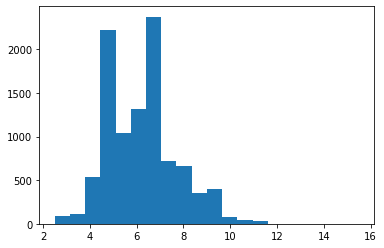

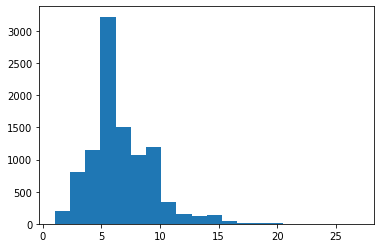

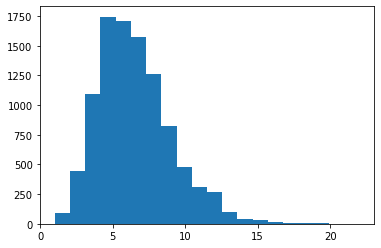

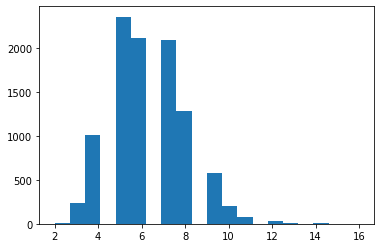

c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


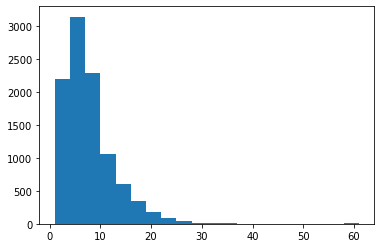

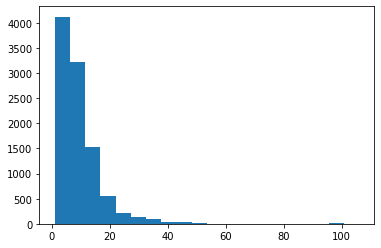

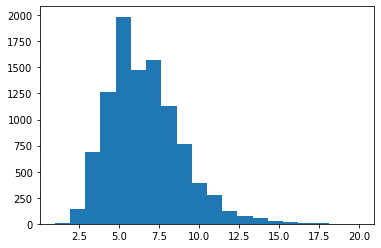

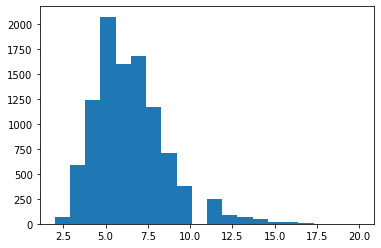

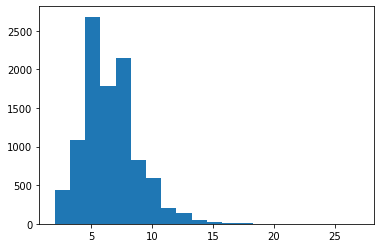

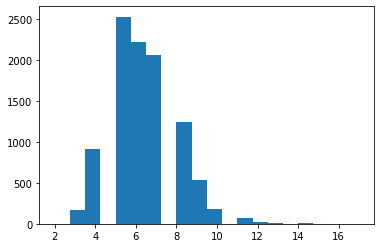

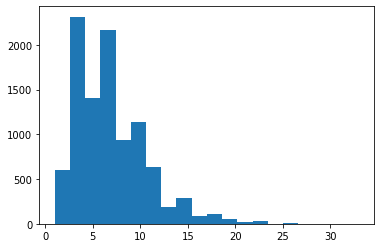

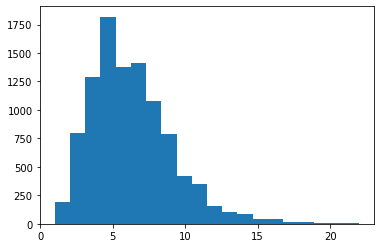

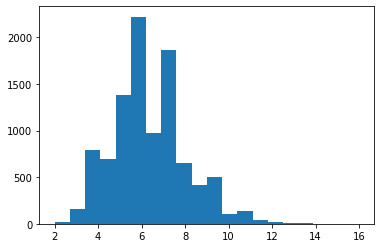

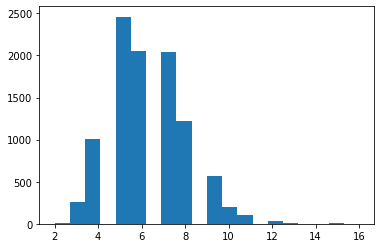

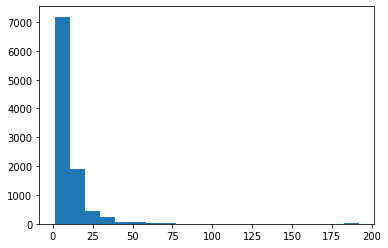

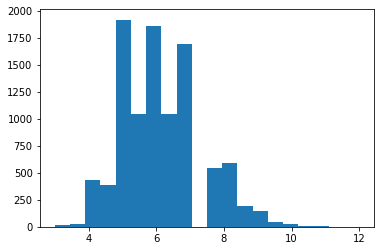

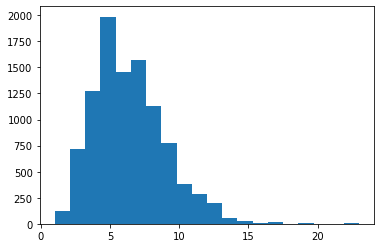

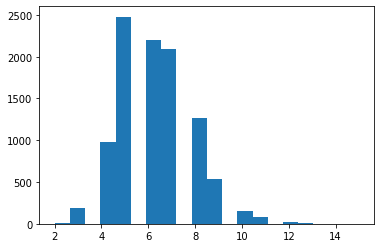

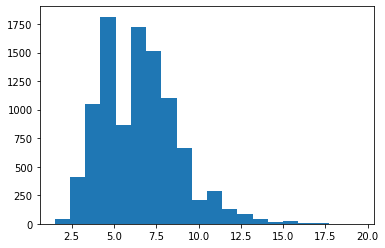

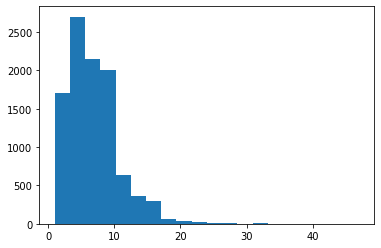

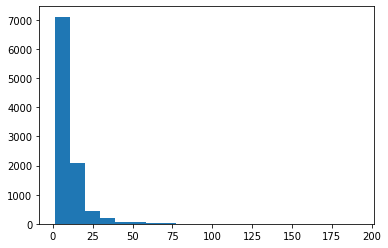

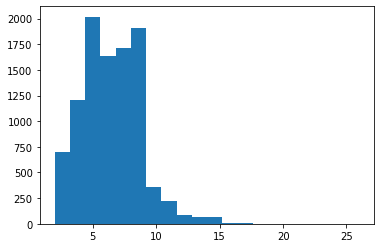

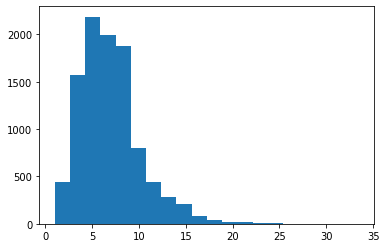

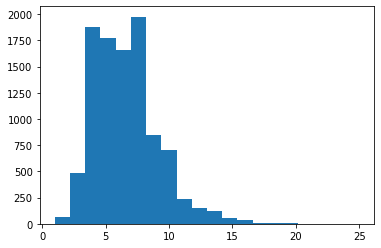

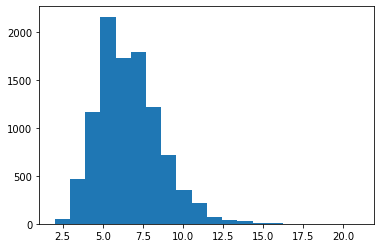

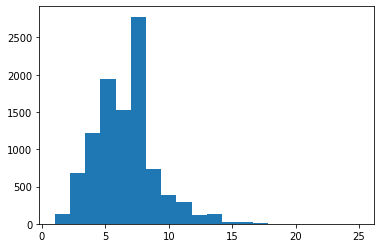

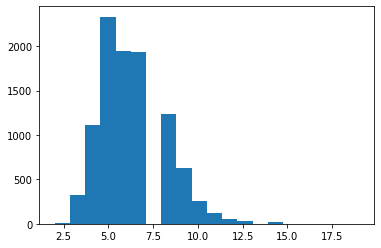

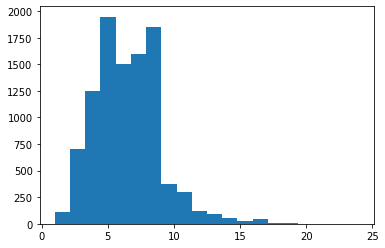

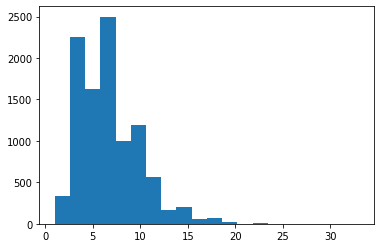

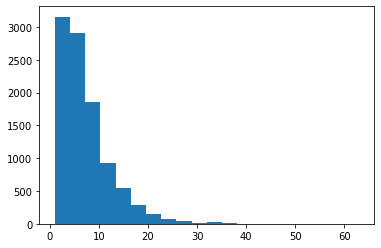

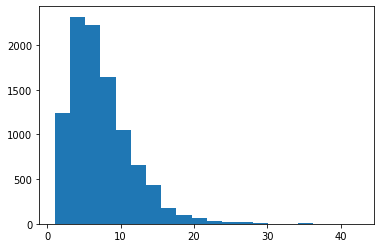

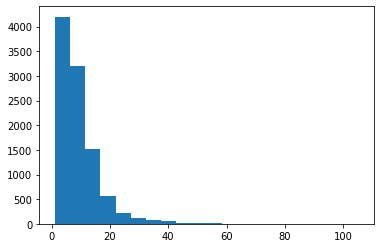

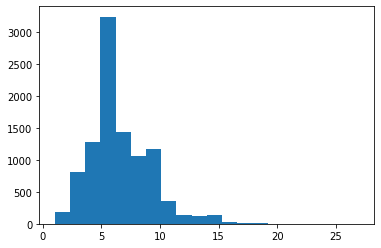

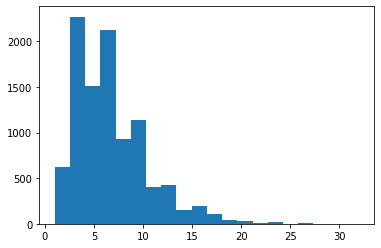

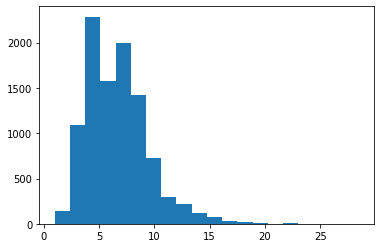

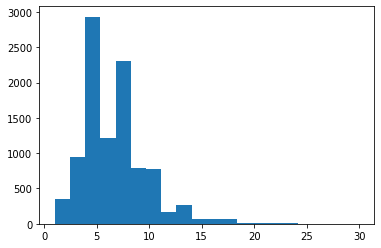

PermissionError: [Errno 13] Permission denied: 'processed_data/06a_splicing_disease_LRs/significance_splicing_disease.csv'

In [25]:
rng = [0.4, 0.55, 0.7]

for m in rng:
    #fetch disease risk list path
    path = glob.glob("/Users/melis/Documents/Gene-targets/Disease_gene_associations_OpenTargets/*.tsv")
    dis_list = []
    #iterate through each disease
    for n in range (0,len(path)):
        disease = glob.glob("/Users/melis/Documents/Gene-targets/Disease_gene_associations_OpenTargets/*.tsv")[n].split("\\")[1].split("_")[0]
        dis = pd.read_csv(path[n], delimiter = '\t', index_col=0)
        dis = dis[(dis['objectObject']>m)]
        # keep only diseases that, at this threshold, have 10 or more genetic associations
        if np.shape(dis)[0]>10:
            dis = pd.read_csv(path[n], delimiter = '\t', index_col=0)
            dis = dis[(dis['objectObject']>m)]
            if np.shape(dis)[0]>10:
                df = dis[(dis['objectObject']>m)]
                df['gene']=df.index
                df.reset_index(inplace = True)
                df = df.drop(columns=['symbol']).set_index(['gene'])
                # calculate the occurance of Ls and Rs in our disease data
                all_source, pctsrc, all_targets, pcttgt, summary_LR = ml.lr.find_hits(df,db)
                # keep list of unique genes that act as L and/or R, calculate number of transcript variants 
                Ls = list(summary_LR[summary_LR['source']>0.0]['gene'])
                Rs = list(summary_LR[summary_LR['target']>0.0]['gene'])
                LRs = list(summary_LR[summary_LR['source+target']!='None']['gene'])
                disease_med_var = ml.lr.total_variants_gene_list(LRs)
                L_disease_med_var = ml.lr.total_variants_gene_list(Ls)
                R_disease_med_var = ml.lr.total_variants_gene_list(Rs)
                # bootstrap random list of LRs expressed in the brain (minus targets), calculate number of transcript variants and store these in a list 
                Ls_vars = ml.lr.bootstrap_genes_return_variants(len(Ls), 10000, list(set(universe) - set(Ls)))
                Rs_vars = ml.lr.bootstrap_genes_return_variants(len(Rs), 10000, list(set(universe) - set(Rs)))
                vars = ml.lr.bootstrap_genes_return_variants(len(LRs), 10000, list(set(universe) - set(LRs)))
                plt.hist(vars, bins=20)
                plt.show()
                
                #We calculate the pval
                pval = np.sum(pd.DataFrame(vars)>disease_med_var)/len(vars)
                L_pval = np.sum(pd.DataFrame(Ls_vars)>L_disease_med_var)/len(Ls_vars)
                R_pval = np.sum(pd.DataFrame(Rs_vars)>R_disease_med_var)/len(Rs_vars)

                #vars_all_diseases.append(disease_med_var)
            dis_list.append(disease)

            if (n==0):
                all_disease_var = np.asarray(disease_med_var).reshape(1,-1)
                L_all_disease_var = np.asarray(L_disease_med_var).reshape(1,-1)
                R_all_disease_var = np.asarray(R_disease_med_var).reshape(1,-1)
                all_pval = pval
                all_Lpval = L_pval
                all_Rpval = R_pval
            else:    
                all_disease_var = np.concatenate((all_disease_var, np.asarray(disease_med_var).reshape(1,-1)), axis = 0)
                L_all_disease_var = np.concatenate((L_all_disease_var, np.asarray(L_disease_med_var).reshape(1,-1)), axis = 0)
                R_all_disease_var = np.concatenate((R_all_disease_var, np.asarray(R_disease_med_var).reshape(1,-1)), axis = 0)
                all_pval = np.concatenate((all_pval, pval), axis = 0)
                all_Lpval = np.concatenate((all_Lpval, L_pval), axis = 0)
                all_Rpval = np.concatenate((all_Rpval, R_pval), axis = 0)
    threshold = np.zeros_like(all_pval)
    threshold[:] = m

    # Store in a dataframe the disease name, number of transcripts (total or median per gene?) and the p-value
    results_L = pd.DataFrame(np.concatenate((np.asarray(dis_list).reshape(1,-1), L_all_disease_var.reshape(1,-1), all_Lpval.reshape(1,-1), threshold.reshape(1,-1)), axis = 0).T, columns = ['Disease', 'Median transcript variants', 'pval', 'Threshold'])
    results_L['type'] = 'Ligand'
    results_R = pd.DataFrame(np.concatenate((np.asarray(dis_list).reshape(1,-1), R_all_disease_var.reshape(1,-1), all_Rpval.reshape(1,-1), threshold.reshape(1,-1)), axis = 0).T, columns = ['Disease', 'Median transcript variants', 'pval', 'Threshold'])
    results_R['type'] = 'Receptor'
    results_LR = pd.DataFrame(np.concatenate((np.asarray(dis_list).reshape(1,-1), all_disease_var.reshape(1,-1), all_pval.reshape(1,-1), threshold.reshape(1,-1)), axis = 0).T, columns = ['Disease', 'Median transcript variants', 'pval', 'Threshold'])
    results_LR['type'] = 'LR'
    results_df = pd.concat([results_LR, results_L, results_R], axis = 0)
    if m == rng[0]:
        all_results_df = results_df

    else:
        all_results_df = pd.concat([all_results_df, results_df], axis = 0)

all_results_df.to_csv('processed_data/06a_splicing_disease_LRs/significance_splicing_disease.csv', index = False)